# Forecasting Client Churn

## Introduction
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

**Interconnect's services**

Interconnect mainly provides two types of services:
1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:
- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

**Data Description**

The data consists of files obtained from different sources:
- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

**Work Plan**
1. Load the data
2. Initial data exploration
3. Data pre-processing
    - Change all column names to underscore and lowercase
    - Fix data types for each dataframe as indicated above
    - Merge the 4 datasets
    - Label Encoding of Yes/No categorical columns (0 for No/NaN, 1 for Yes)
    - Add a feature indicating if a customer is active/inactive as the new target as 'churn'
4. Exploratory Data Analysis
    - Explore the data in-depth
    - Explore trends & seasonality in BeginDate and EndDate
6. Feature Engineering
    - Change missing values to 'Unknown'
    - Add a feature showing length of contract in days as of February 1, 2020 if still active
    - Create calendar features from BeginDate (year, month, day)
    - Drop customerID, BeginDate & EndDate
    - One-Hot Encoding of categorical columns
7. Split into training/validation/test datasets
8. Account for class imbalance
9. Feature scaling
11. Modeling
    - Evaluate models using target metrics: AUC-ROC and Accuracy
    - Create a baseline classification model
    - Compare additional classification models (Logistic Regression, Decision Tree, Random Forest, XGBoost) with hyperparameter tuning and cross-validation
12. Final model
    - Select the best model based on target metrics, train it on the full training+validation set and evaluate it's performance

## Initialization

In [156]:
# Data processing
import pandas as pd
import numpy as np

# Data analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from imblearn.over_sampling import SMOTE
from collections import Counter

# Model and performance
import sklearn
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## Load Data

In [2]:
contract = pd.read_csv('/Users/laceymalarky/git_projects/python-exercises/TripleTen/datasets/final_project/contract.csv')
internet = pd.read_csv('/Users/laceymalarky/git_projects/python-exercises/TripleTen/datasets/final_project/internet.csv')
personal = pd.read_csv('/Users/laceymalarky/git_projects/python-exercises/TripleTen/datasets/final_project/personal.csv')
phone = pd.read_csv('/Users/laceymalarky/git_projects/python-exercises/TripleTen/datasets/final_project/phone.csv')

## Pre-processing

In [3]:
# Merge all datasets
df = contract.set_index('customerID').join(internet.set_index('customerID')).join(personal.set_index('customerID')).join(phone.set_index('customerID'))
df = df.reset_index()

In [4]:
# Change all column names to underscore and lowercase
df.columns = ['customer_ID', 'Begin_Date', 'End_Date', 'Type', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charges', 'Total_Charges', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Multiple_Lines']
df.columns = df.columns.str.lower()

**Add churn feature**

In [5]:
df['churn'] = np.where(df.end_date == 'No', 0, 1)

**Fix data types**

In [6]:
df.begin_date = pd.to_datetime(df.begin_date)

# Change end dates of 'No' to the last month for which we have data, Feb 1, 2020
df['end_date'] = df.end_date.where(df.end_date != 'No', '2020-02-01 00:00:00')
df.end_date = pd.to_datetime(df.end_date, format='%Y-%m-%d %H:%M:%S')

**Add Duration of contract feature**

In [7]:
df['duration_days'] = (df.end_date - df.begin_date).dt.days

In [8]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,61


In [9]:
# There are some total charges that are blank because they are in the first month of their contract, change those to zero
df.total_charges = pd.to_numeric(df.total_charges, errors='coerce')
df.total_charges = df.total_charges.where(~df.total_charges.isna(), 0)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_tv       5517 non-null   object        
 14  streamin

In [11]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,61


**Change Yes/No features to Boolean**

In [12]:
#Check that NaNs and No's are set to zero with one column as an example
df.multiple_lines.value_counts(dropna=False)

multiple_lines
No     3390
Yes    2971
NaN     682
Name: count, dtype: int64

In [13]:
df.paperless_billing = np.where(df.paperless_billing == 'Yes', 1, 0)
df.online_security = np.where(df.online_security == 'Yes', 1, 0)
df.online_backup = np.where(df.online_backup == 'Yes', 1, 0)
df.device_protection = np.where(df.device_protection == 'Yes', 1, 0)
df.tech_support = np.where(df.tech_support == 'Yes', 1, 0)
df.streaming_tv = np.where(df.streaming_tv == 'Yes', 1, 0)
df.streaming_movies = np.where(df.streaming_movies == 'Yes', 1, 0)
df.partner = np.where(df.partner == 'Yes', 1, 0)
df.dependents = np.where(df.dependents == 'Yes', 1, 0)
df.multiple_lines = np.where(df.multiple_lines == 'Yes', 1, 0)

In [14]:
#Check that NaNs and No's are set to zero with one column as an example
df.multiple_lines.value_counts(dropna=False)

multiple_lines
0    4072
1    2971
Name: count, dtype: int64

In [15]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,...,0,0,0,Female,0,1,0,0,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,DSL,1,...,0,0,0,Male,0,0,0,0,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,...,0,0,0,Male,0,0,0,0,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,...,1,0,0,Male,0,0,0,0,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,...,0,0,0,Female,0,0,0,0,1,61


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    7043 non-null   int64         
 10  online_backup      7043 non-null   int64         
 11  device_protection  7043 non-null   int64         
 12  tech_support       7043 non-null   int64         
 13  streaming_tv       7043 non-null   int64         
 14  streamin

## Exploratory Data Analysis

In [17]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

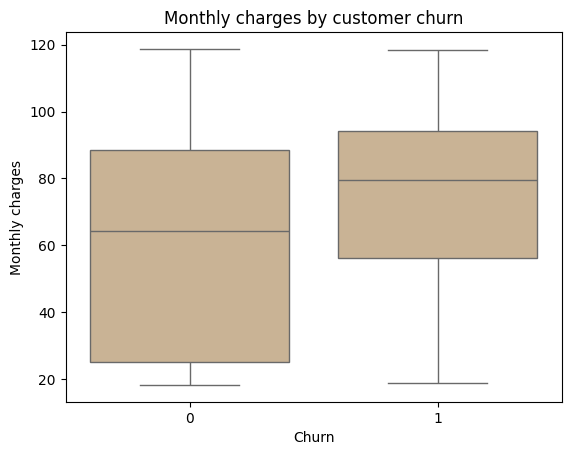

In [18]:
# Plot boxplots of categorical variables against the target: Price
sns.boxplot(data=df, x="churn", y="monthly_charges", color='tan').set_title('Monthly charges by customer churn')
plt.ylabel('Monthly charges')
plt.xlabel('Churn')
plt.show()

- The boxplot above shows that the median monthly charges for clients that churn is slightly higher than those that stay.

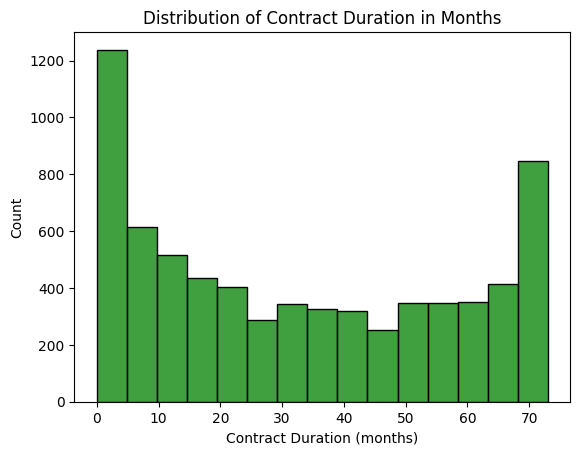

In [19]:
sns.histplot(df.duration_days/30, color='green').set_title('Distribution of Contract Duration in Months')
plt.xlabel('Contract Duration (months)')
plt.show()

- The bar chart above shows that the distribution is bimodal, there is a peak less than 5 months and a peak around 70 months.

In [20]:
# Churn rate by contract type and service
df[['churn','internet_service','type']].groupby(['type','internet_service']).agg(['mean','count'])

churn      
                                     mean count
type           internet_service                
Month-to-month DSL               0.322159  1223
               Fiber optic       0.546053  2128
One year       DSL               0.092982   570
               Fiber optic       0.192950   539
Two year       DSL               0.019108   628
               Fiber optic       0.072261   429

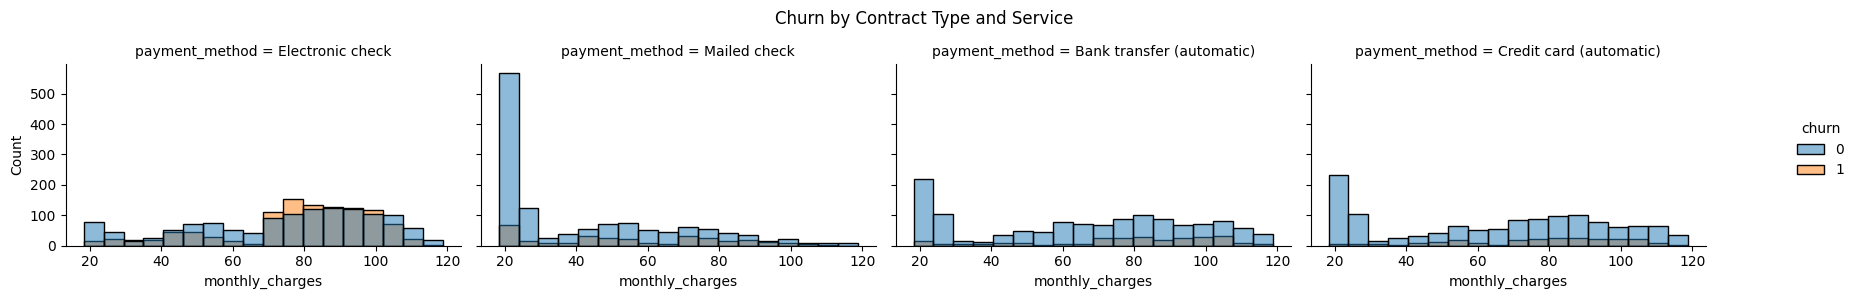

In [21]:
# Plot churn by type and internet service
fig1 = sns.displot(df, x="monthly_charges", col="payment_method", hue='churn', 
            facet_kws=dict(margin_titles=True),
            height=3, aspect=1.5)
fig1.fig.subplots_adjust(top=.8)
fig1.fig.suptitle('Churn by Contract Type and Service')
plt.show()

- Higher churn rate seen in clients that pay by electronic check

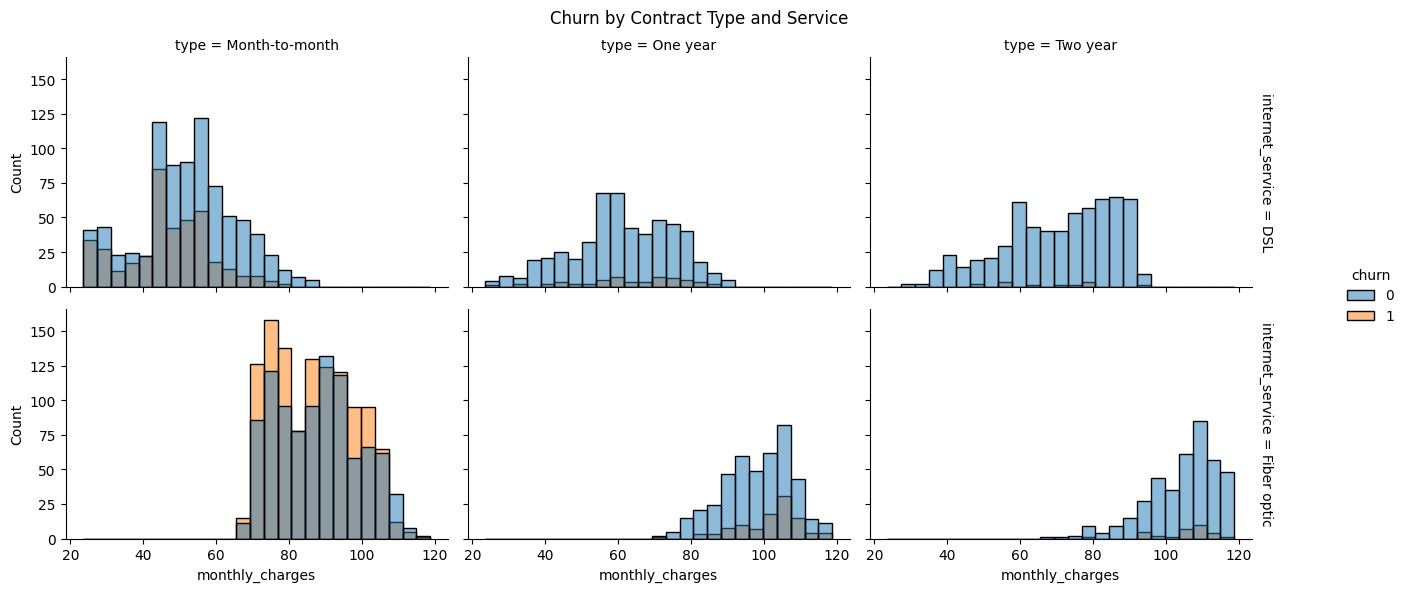

In [22]:
# Plot churn by type and internet service
fig1 = sns.displot(df, x="monthly_charges", col="type", row="internet_service", hue='churn', 
            facet_kws=dict(margin_titles=True),
            height=3, aspect=1.5)
fig1.fig.subplots_adjust(top=.9)
fig1.fig.suptitle('Churn by Contract Type and Service')
plt.show()

- Month-to-month contracts have the highest churn rate
- Two year contracts have the lowest churn rate
- Fiber optic clients have a higher churn rate compared to DSL for each contract type
- Highest churn rate is month-to-month fiber optic customers

In [23]:
# Churn rate by gender
df[['churn','gender']].groupby(['gender']).agg(['mean','count'])

churn      
            mean count
gender                
Female  0.269209  3488
Male    0.261603  3555

- Churn rate between males and females are similar.

In [24]:
df.describe()

,begin_date,end_date,paperless_billing,monthly_charges,total_charges,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,multiple_lines,churn,duration_days
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2020-01-11 12:56:19.696152320,0.592219,64.761692,2279.734304,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.162147,0.483033,0.299588,0.421837,0.265370,985.996166
min,2013-10-01 00:00:00,2019-10-01 00:00:00,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-01-01 00:00:00,0.000000,35.500000,398.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,273.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,1.000000,70.350000,1394.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,883.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,1.000000,89.850000,3786.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1676.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2191.000000
std,NaN,NaN,0.491457,30.090047,2266.794470,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.368612,0.499748,0.458110,0.493888,0.441561,747.587844


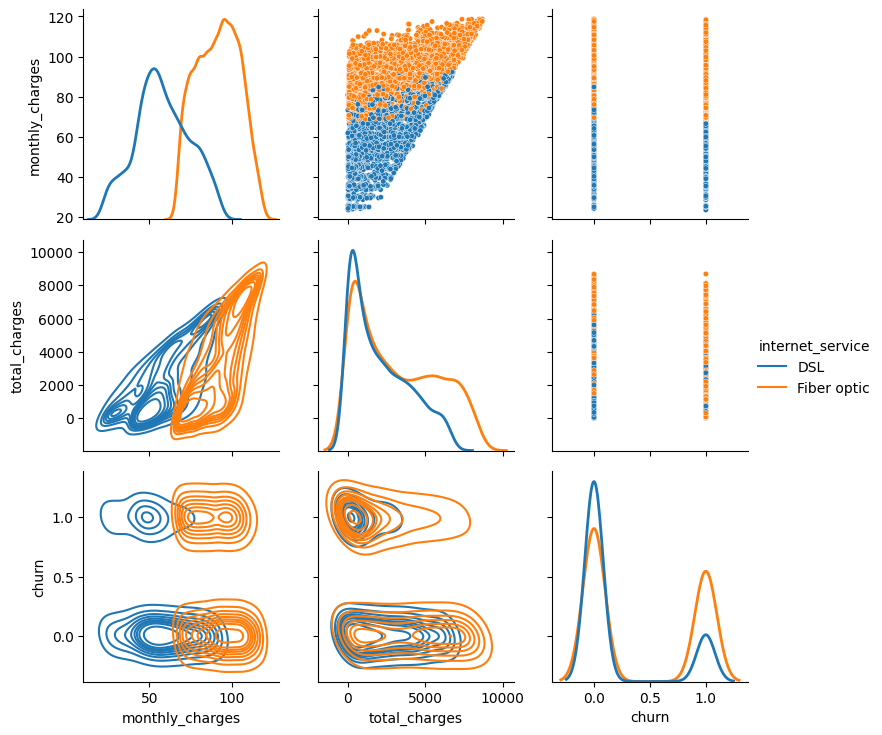

In [25]:
# Explore charges and churn by service type
g = sns.PairGrid(df[['monthly_charges','total_charges', 'churn', 'internet_service']], diag_sharey=False, hue='internet_service')
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
g.add_legend()
plt.show()

- Monthly charges for Fiber optic are more expensive than DSL
- Total charges are positively skewed for both service types, with a median around $1400
- Churn rate is higher for fiber optic clients

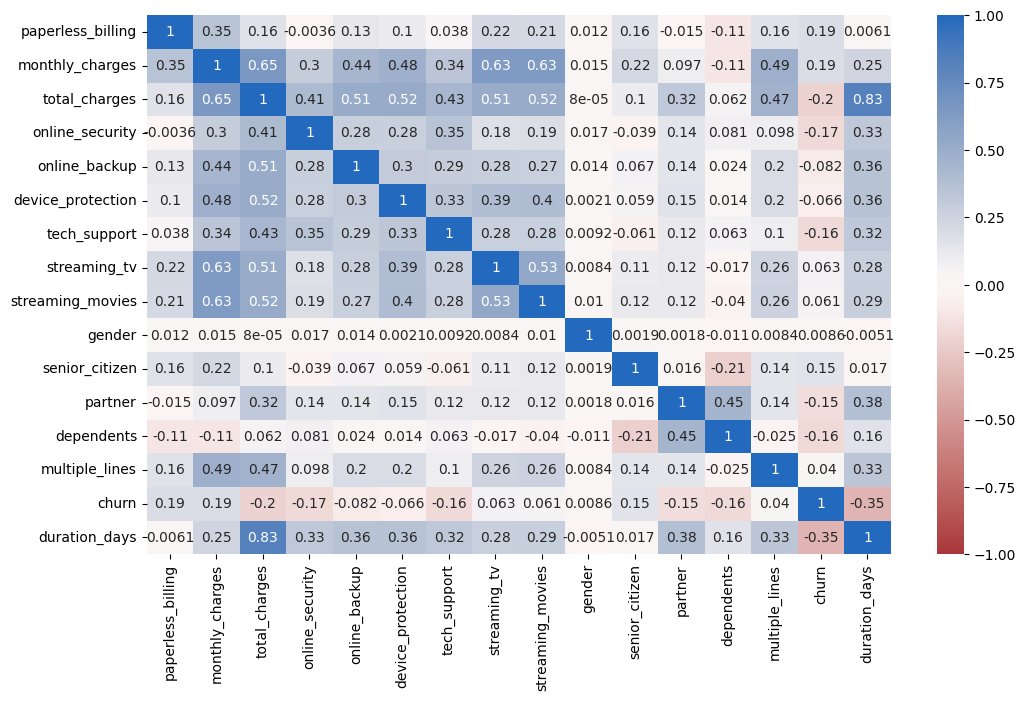

In [26]:
# Correlation of features
df_corr = df.drop(columns=['customer_id', 'begin_date', 'end_date', 'type', 'payment_method', 'internet_service'])
df_corr['gender'].replace({'Male':0, 'Female':1}, inplace=True)

plt.figure(figsize=(12,7))
sns.heatmap(df_corr.corr(), annot=True, cmap='vlag_r', vmin=-1, vmax=1)
plt.show()

- Paperless billing, monthly charges and senior citizen columns have a weak positive correlation with customer churn.
- There is a weak negative correlation between total charges, online security, tech support, partner and dependents with customer churn.
- Streaming tv and movies are positively correlated with monthly charges. Having streaming services increases monthly cost.

In [27]:
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

- Churn feature is imbalanced

**Explore trends & seasonality in contract begin date**

In [28]:
df_ts = df.set_index('begin_date')

In [29]:
df_ts.head()

,customer_id,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn,duration_days
begin_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7590-VHVEG,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,...,0,0,0,Female,0,1,0,0,0,31
2017-04-01,5575-GNVDE,2020-02-01,One year,0,Mailed check,56.95,1889.50,DSL,1,0,...,0,0,0,Male,0,0,0,0,0,1036
2019-10-01,3668-QPYBK,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,...,0,0,0,Male,0,0,0,0,1,61
2016-05-01,7795-CFOCW,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,0,...,1,0,0,Male,0,0,0,0,0,1371
2019-09-01,9237-HQITU,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,...,0,0,0,Female,0,0,0,0,1,61


In [30]:
df_ts.sort_index(inplace = True)

In [31]:
# Check that the index is in chronological order
df_ts.index.is_monotonic_increasing

True

In [32]:
df_ts = df_ts[['churn']]

In [33]:
# Resample total charges each month
df_ts = df_ts.resample('1M').mean()

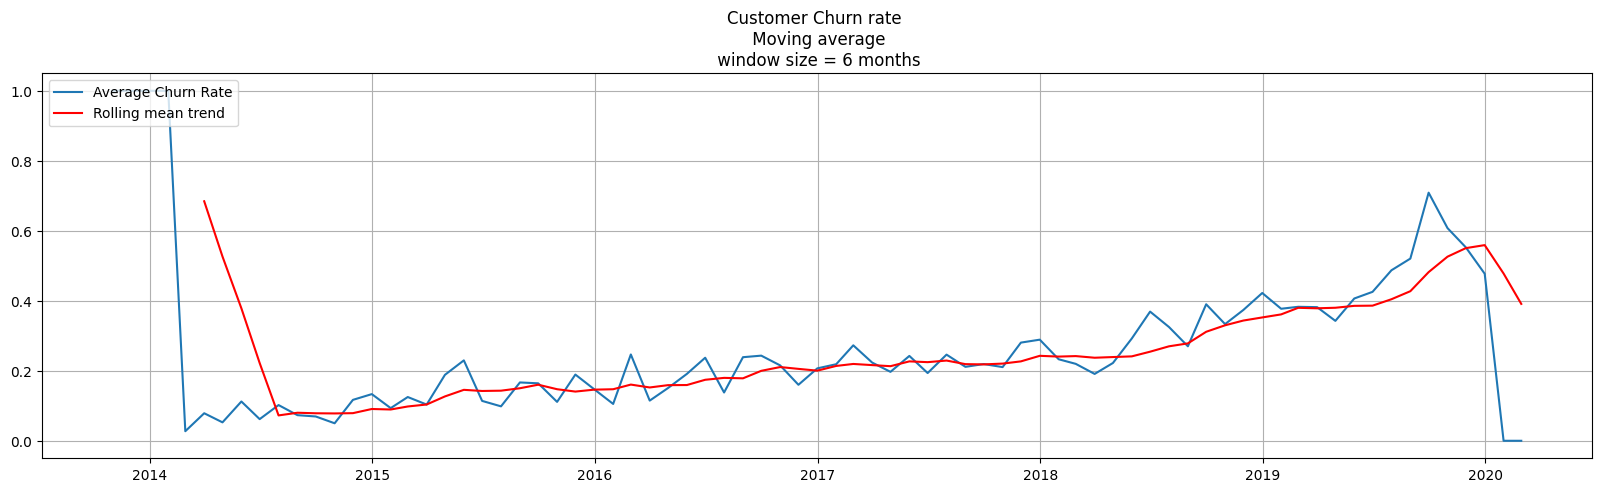

In [34]:
# Plot data with moving average
window = 6
rolling_mean = df_ts.rolling(window=window).mean()

plt.figure(figsize=(20,5))
plt.title(f'Customer Churn rate \n Moving average\n window size = {window} months')
plt.plot(df_ts,  label='Average Churn Rate')
plt.plot(rolling_mean, 'r', label="Rolling mean trend")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

- Average churn rate has been increasing since 2014

In [35]:
decomposed = seasonal_decompose(df_ts)

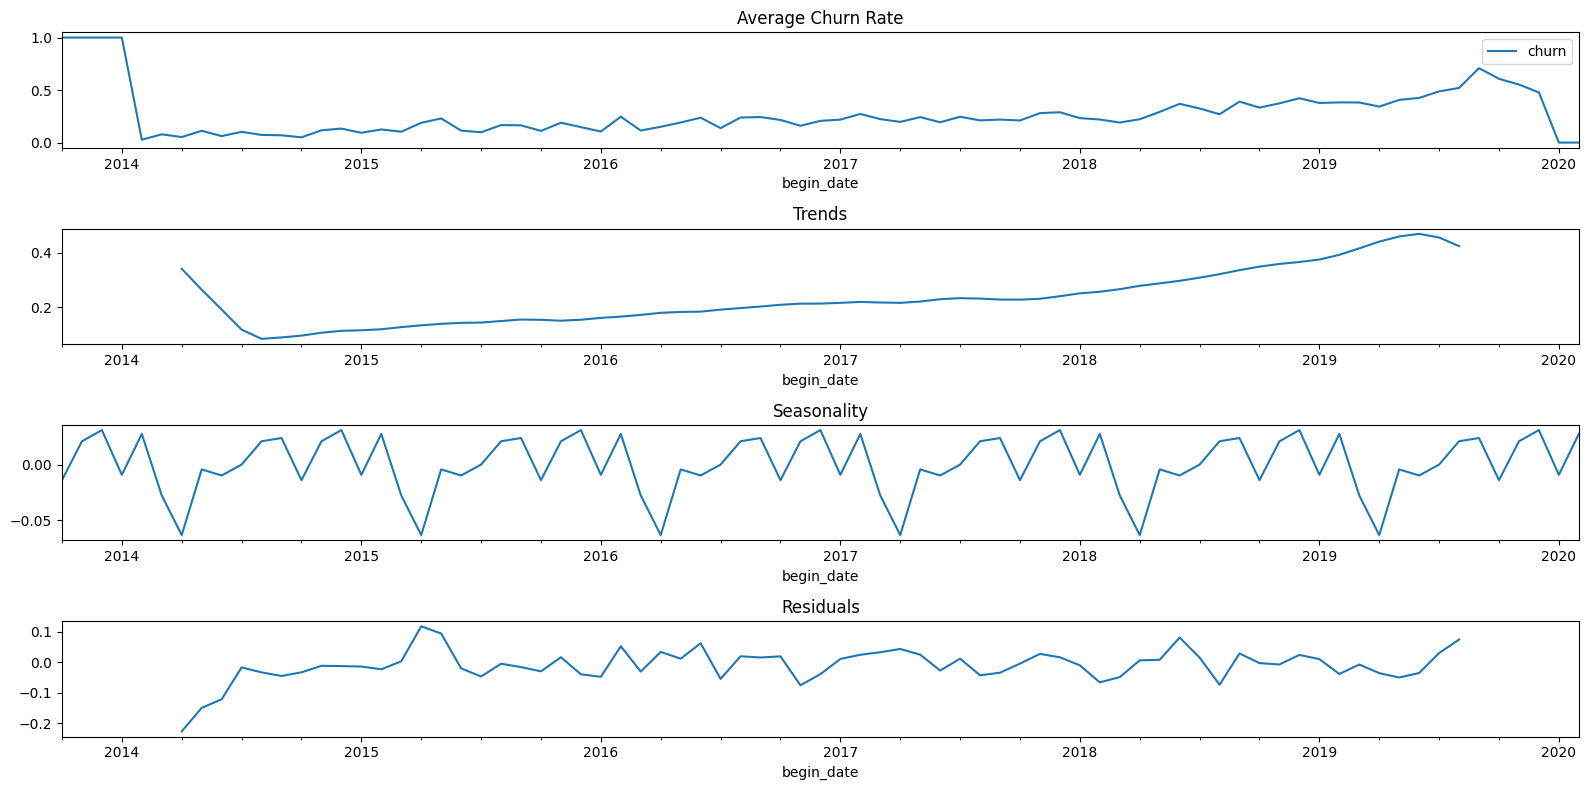

In [36]:
plt.figure(figsize=(16,8))

plt.subplot(411)
df_ts.plot(ax=plt.gca())
plt.title('Average Churn Rate')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trends')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

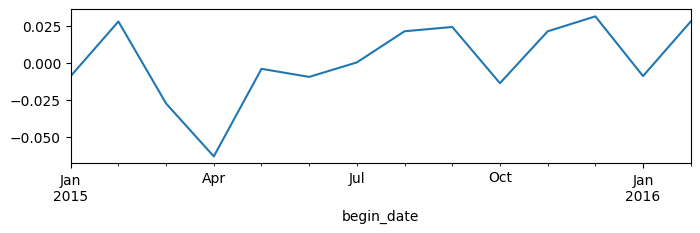

In [37]:
# Seasonailty subset
decomposed.seasonal['2015-01-01':'2016-03-01'].plot(figsize=(8,2))
plt.show()

In [38]:
print(f'Trend max: {round(decomposed.trend.min(),2)}, trend min:{round(decomposed.trend.max(),2)}')
print(f'Seasonal max: {round(decomposed.seasonal.min(),2)}, seasonal min:{round(decomposed.seasonal.max(),2)}')
print(f'Residual max: {round(decomposed.resid.min(),2)}, residual min:{round(decomposed.resid.max(),2)}')

Trend max: 0.08, trend min:0.47
Seasonal max: -0.06, seasonal min:0.03
Residual max: -0.23, residual min:0.12


- The trend in churn rate is increasing, from 8% to 47% from 2014-2020
- There is  seasonality within a 1-year period
    - Annual swings of about 9%
    - Lowest churn rate in April
    - Peaks in churn rate in February, September and December
- Residuals show about 3% variability from month to month

## Feature Engineering

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    7043 non-null   int64         
 10  online_backup      7043 non-null   int64         
 11  device_protection  7043 non-null   int64         
 12  tech_support       7043 non-null   int64         
 13  streaming_tv       7043 non-null   int64         
 14  streamin

In [40]:
df.internet_service = df.internet_service.where(~df.internet_service.isna(), 'Unknown')

In [41]:
df.internet_service.value_counts(dropna=False)

internet_service
Fiber optic    3096
DSL            2421
Unknown        1526
Name: count, dtype: int64

In [42]:
# Add calendar features for begin date - REMOVED
#df['begin_date_year'] = df.begin_date.dt.year
#df['begin_date_month'] = df.begin_date.dt.month

In [42]:
# Drop customer and date features not needed for modeling
df.drop(columns=['customer_id', 'begin_date', 'end_date'], inplace=True)

**One-Hot Encoding**

In [44]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn,duration_days
0,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,Female,0,1,0,0,0,31
1,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,Male,0,0,0,0,0,1036
2,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,1,0,0,0,0,Male,0,0,0,0,1,61
3,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,0,1,1,0,0,Male,0,0,0,0,0,1371
4,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,0,0,0,0,0,Female,0,0,0,0,1,61


In [45]:
# Rename categorical variables to snake case before OHE
df['payment_method'] = df['payment_method'].str.lower().replace({' ':'_'}, regex=True)
df['internet_service'] = df['internet_service'].str.lower().replace({' ':'_'}, regex=True)
df['gender'] = df['gender'].str.lower().replace({' ':'_'}, regex=True)
df['type'] = df['type'].str.lower().replace({' ':'_'}, regex=True)

In [182]:
# OHE
df_ohe = pd.get_dummies(df, drop_first=True)

In [184]:
# Change Boolean to 0/1
df_ohe.type_one_year = np.where(df_ohe.type_one_year == True, 1, 0)
df_ohe.type_two_year = np.where(df_ohe.type_two_year == True, 1, 0)
df_ohe['payment_method_credit_card_(automatic)'] = np.where(df_ohe['payment_method_credit_card_(automatic)'] == True, 1, 0)
df_ohe.payment_method_electronic_check = np.where(df_ohe.payment_method_electronic_check == True, 1, 0)
df_ohe.payment_method_mailed_check = np.where(df_ohe.payment_method_mailed_check == True, 1, 0)
df_ohe.internet_service_fiber_optic = np.where(df_ohe.internet_service_fiber_optic == True, 1, 0)
df_ohe.internet_service_unknown = np.where(df_ohe.internet_service_unknown == True, 1, 0)
df_ohe.gender_male = np.where(df_ohe.gender_male == True, 1, 0)

In [185]:
df_ohe.head()

,paperless_billing,monthly_charges,total_charges,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,...,churn,duration_days,type_one_year,type_two_year,payment_method_credit_card_(automatic),payment_method_electronic_check,payment_method_mailed_check,internet_service_fiber_optic,internet_service_unknown,gender_male
0,1,29.85,29.85,0,1,0,0,0,0,0,...,0,31,0,0,0,1,0,0,0,0
1,0,56.95,1889.50,1,0,1,0,0,0,0,...,0,1036,1,0,0,0,1,0,0,1
2,1,53.85,108.15,1,1,0,0,0,0,0,...,1,61,0,0,0,0,1,0,0,1
3,0,42.30,1840.75,1,0,1,1,0,0,0,...,0,1371,1,0,0,0,0,0,0,1
4,1,70.70,151.65,0,0,0,0,0,0,0,...,1,61,0,0,0,1,0,1,0,0


In [186]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       7043 non-null   int64  
 1   monthly_charges                         7043 non-null   float64
 2   total_charges                           7043 non-null   float64
 3   online_security                         7043 non-null   int64  
 4   online_backup                           7043 non-null   int64  
 5   device_protection                       7043 non-null   int64  
 6   tech_support                            7043 non-null   int64  
 7   streaming_tv                            7043 non-null   int64  
 8   streaming_movies                        7043 non-null   int64  
 9   senior_citizen                          7043 non-null   int64  
 10  partner                                 7043 non-null   int6

## Split data into train/test

In [187]:
# Set target features
X_ohe = df_ohe.drop(columns=['churn'])
y_ohe = df_ohe['churn']

# Split data
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_ohe, y_ohe, test_size=0.20, random_state=0)
X_train, X_valid, y_train, y_valid =  train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=0)

In [188]:
print(f'Training set: {X_train.shape}, {len(X_train)/len(df):0.0%}')
print(f'Validation set: {X_valid.shape}, {len(X_valid)/len(df):0.0%}')
print(f'Test set: {X_test.shape}, {len(X_test)/len(df):0.0%}')

Training set: (4225, 22), 60%
Validation set: (1409, 22), 20%
Test set: (1409, 22), 20%


## Class Imbalance using SMOTE

In [189]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 3089, 1: 1136})


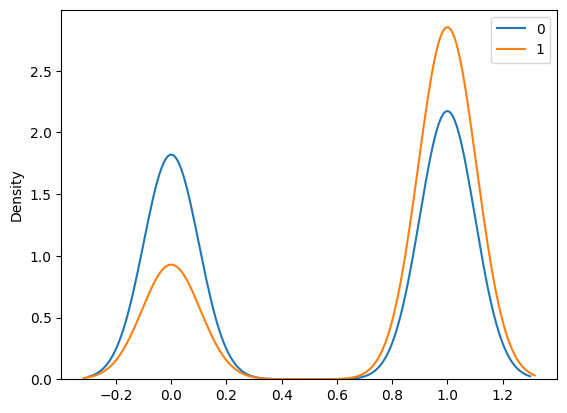

In [190]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_train.values == label)[0]
    sns.kdeplot(X_train.values[row_ix, 0], label=str(label))
plt.legend()
plt.show()

In [191]:
# transform the dataset, upsampling the monority class
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [192]:
# summarize the new class distribution
counter = Counter(y_train_res)
print(counter)

Counter({0: 3089, 1: 3089})


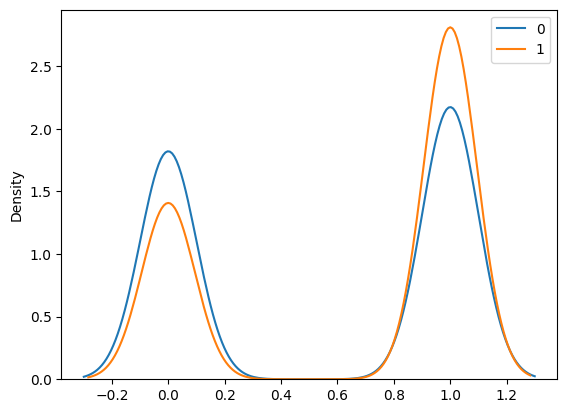

In [193]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_train_res.values == label)[0]
    sns.kdeplot(X_train_res.values[row_ix, 0], label=str(label))
plt.legend()
plt.show()

In [194]:
# Before Upsampling
y_train.value_counts()

churn
0    3089
1    1136
Name: count, dtype: int64

In [195]:
# After Upsampling
y_train_res.value_counts()

churn
0    3089
1    3089
Name: count, dtype: int64

- Target feature in the training set is now balanced

## Evaluation procedure

In [60]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    '''
    Plots F1, ROC-AUC Curve and PRC Curve for training and test sets.
    '''
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        #Confusion matrix
        if type == 'test':
            ax = axs[3]
            conf_matrix = metrics.confusion_matrix(target, pred_target)
            sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
            plt.ylabel('Actual label');
            plt.xlabel('Predicted label');
            plt.title('Confusion matrix (test)')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Model training

In [159]:
#Initialize Scaler
scaler = StandardScaler()

### Constant model (baseline)

          train  test
Accuracy    0.5  0.74
F1          0.0  0.00
APS         0.5  0.26
ROC AUC     0.5  0.50


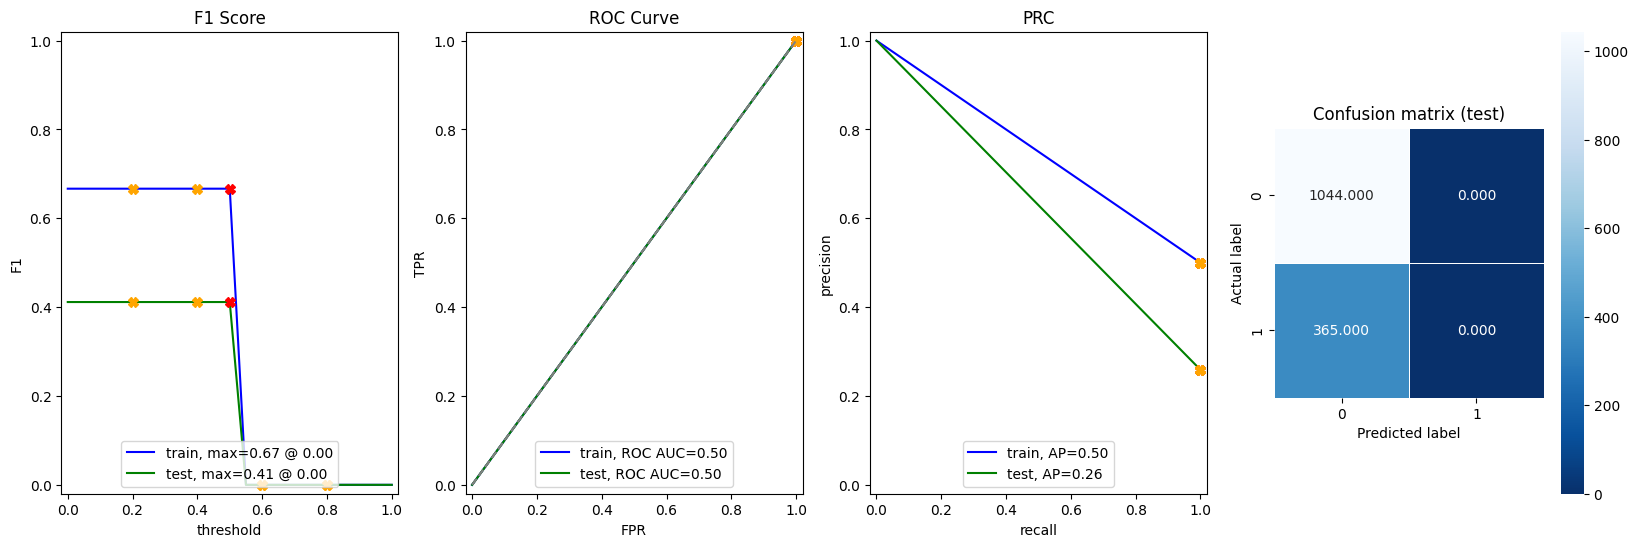

In [62]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(random_state=0)
dummy_clf.fit(X_train_res, y_train_res)

evaluate_model(dummy_clf, X_train_res, y_train_res, X_valid, y_valid)

### Logistic Regression

CPU times: user 8 µs, sys: 6 µs, total: 14 µs
Wall time: 1.72 ms
Best C: 0.02811768697974228

LogisticRegression(C=0.02811768697974228, random_state=0)
          train  test
Accuracy   0.83  0.77
F1         0.83  0.60
APS        0.91  0.59
ROC AUC    0.91  0.83


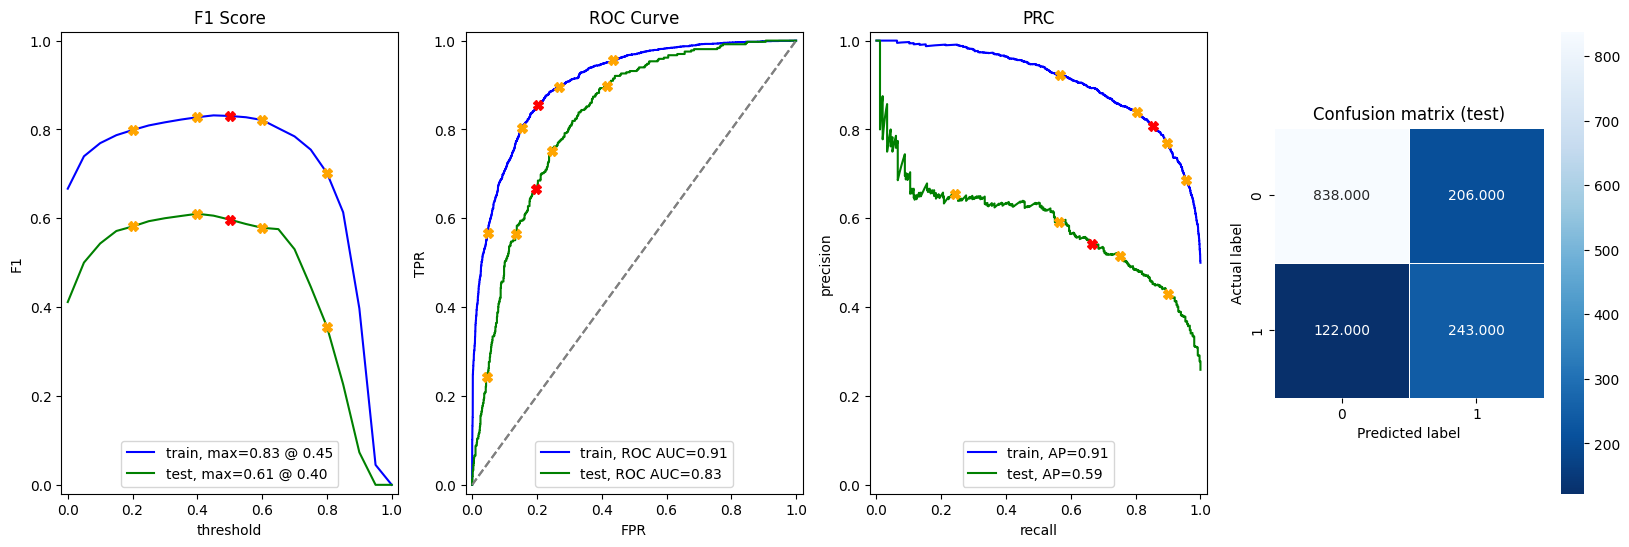

In [65]:
%time
model_lr = LogisticRegression(random_state=0)
pipe = Pipeline([('scaler', scaler), ('model_lr', model_lr)])

# set parameters
C = np.logspace(-4, 4, 50)
parameters = dict(model_lr__C=C)

lr_GS = GridSearchCV(pipe, parameters)
lr_GS.fit(X_train_res, y_train_res)

print('Best C:', lr_GS.best_estimator_.get_params()['model_lr__C'])
print(); print(lr_GS.best_estimator_.get_params()['model_lr'])

evaluate_model(lr_GS, X_train_res, y_train_res, X_valid, y_valid)

### Decision Tree

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits
Best max_depth: 11
Best min_samples_split: 2
Best max_leaf_nodes: None
Best min_samples_leaf: 1

DecisionTreeClassifier(max_depth=11, random_state=0)
          train  test
Accuracy   0.90  0.76
F1         0.91  0.59
APS        0.95  0.54
ROC AUC    0.96  0.79
CPU times: user 37.2 s, sys: 512 ms, total: 37.7 s
Wall time: 37.6 s


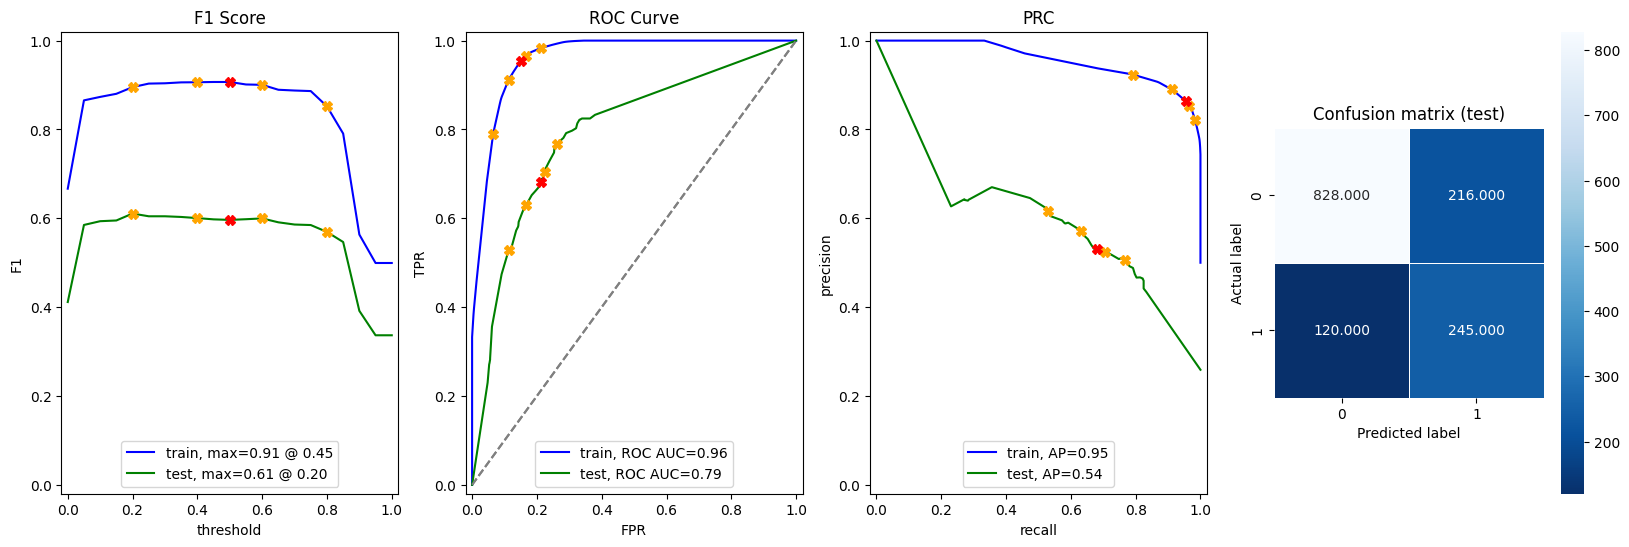

In [66]:
%%time
model_dt = DecisionTreeClassifier(random_state=0)
pipe = Pipeline([('scaler', scaler), ('model_dt', model_dt)])

depth = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, None]
min_samples_split = range(2,10)
max_leaf_nodes = [3, 6, 9, None]
min_samples_leaf = [1, 2, 3]

parameters = dict(model_dt__max_depth=depth,
                 model_dt__min_samples_split=min_samples_split,
                 model_dt__max_leaf_nodes=max_leaf_nodes,
                 model_dt__min_samples_leaf=min_samples_leaf)

dt_GS = GridSearchCV(pipe, parameters, cv=3, verbose=1)
dt_GS.fit(X_train_res, y_train_res)

print('Best max_depth:', dt_GS.best_estimator_.get_params()['model_dt__max_depth'])
print('Best min_samples_split:', dt_GS.best_estimator_.get_params()['model_dt__min_samples_split'])
print('Best max_leaf_nodes:', dt_GS.best_estimator_.get_params()['model_dt__max_leaf_nodes'])
print('Best min_samples_leaf:', dt_GS.best_estimator_.get_params()['model_dt__min_samples_leaf'])

print(); print(dt_GS.best_estimator_.get_params()['model_dt'])

evaluate_model(dt_GS, X_train_res, y_train_res, X_valid, y_valid)

### Random Forest

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
Best n_estimators: 150
Best max_depth: None
Best min_samples_split: 4
Best max_leaf_nodes: None
Best min_samples_leaf: 1

RandomForestClassifier(min_samples_split=4, n_estimators=150, random_state=0)
          train  test
Accuracy   0.99  0.80
F1         0.99  0.60
APS        1.00  0.68
ROC AUC    1.00  0.85
CPU times: user 7min 59s, sys: 14.4 s, total: 8min 13s
Wall time: 8min 13s


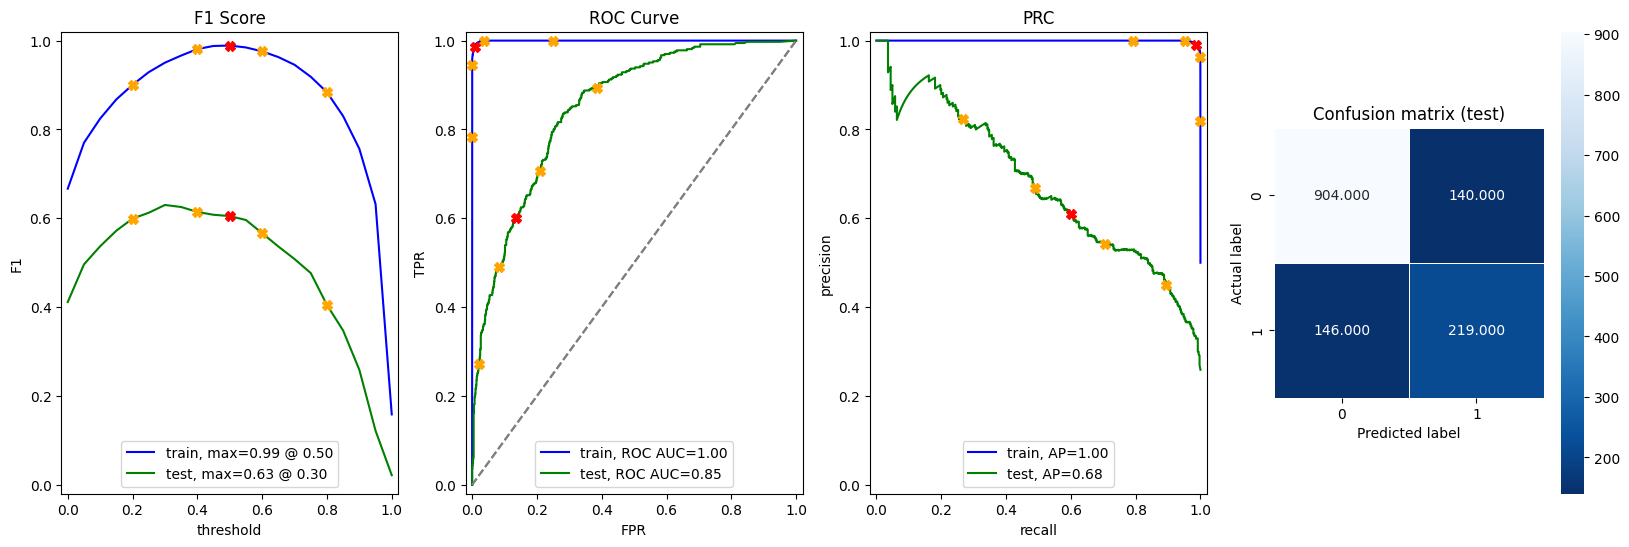

In [67]:
%%time
model_rf = RandomForestClassifier(random_state=0)
pipe = Pipeline([('scaler', scaler), ('model_rf', model_rf)])

n_estimators = range(50, 201, 25)
depth = [3, 5, 7, None]
min_samples_split = range(2,8,2)
max_leaf_nodes = [3, 6, 9, None]
min_samples_leaf = [1, 2, 3]

parameters = dict(model_rf__n_estimators=n_estimators,
                 model_rf__max_depth=depth,
                 model_rf__min_samples_split=min_samples_split,
                 model_rf__max_leaf_nodes=max_leaf_nodes,
                 model_rf__min_samples_leaf=min_samples_leaf)

rf_GS = GridSearchCV(pipe, parameters, cv=3, verbose=1)
rf_GS.fit(X_train_res, y_train_res)

print('Best n_estimators:', rf_GS.best_estimator_.get_params()['model_rf__n_estimators'])
print('Best max_depth:', rf_GS.best_estimator_.get_params()['model_rf__max_depth'])
print('Best min_samples_split:', rf_GS.best_estimator_.get_params()['model_rf__min_samples_split'])
print('Best max_leaf_nodes:', rf_GS.best_estimator_.get_params()['model_rf__max_leaf_nodes'])
print('Best min_samples_leaf:', rf_GS.best_estimator_.get_params()['model_rf__min_samples_leaf'])

print(); print(rf_GS.best_estimator_.get_params()['model_rf'])

evaluate_model(rf_GS, X_train_res, y_train_res, X_valid, y_valid)

### XGBoost

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Best score: {'model_xgb__base_score': 0.9, 'model_xgb__booster': 'gbtree', 'model_xgb__learning_rate': 0.2, 'model_xgb__n_estimators': 135, 'model_xgb__reg_alpha': 0.5}
          train  test
Accuracy   0.97  0.83
F1         0.97  0.66
APS        1.00  0.76
ROC AUC    1.00  0.88
CPU times: user 3min 29s, sys: 1min 36s, total: 5min 6s
Wall time: 39.4 s


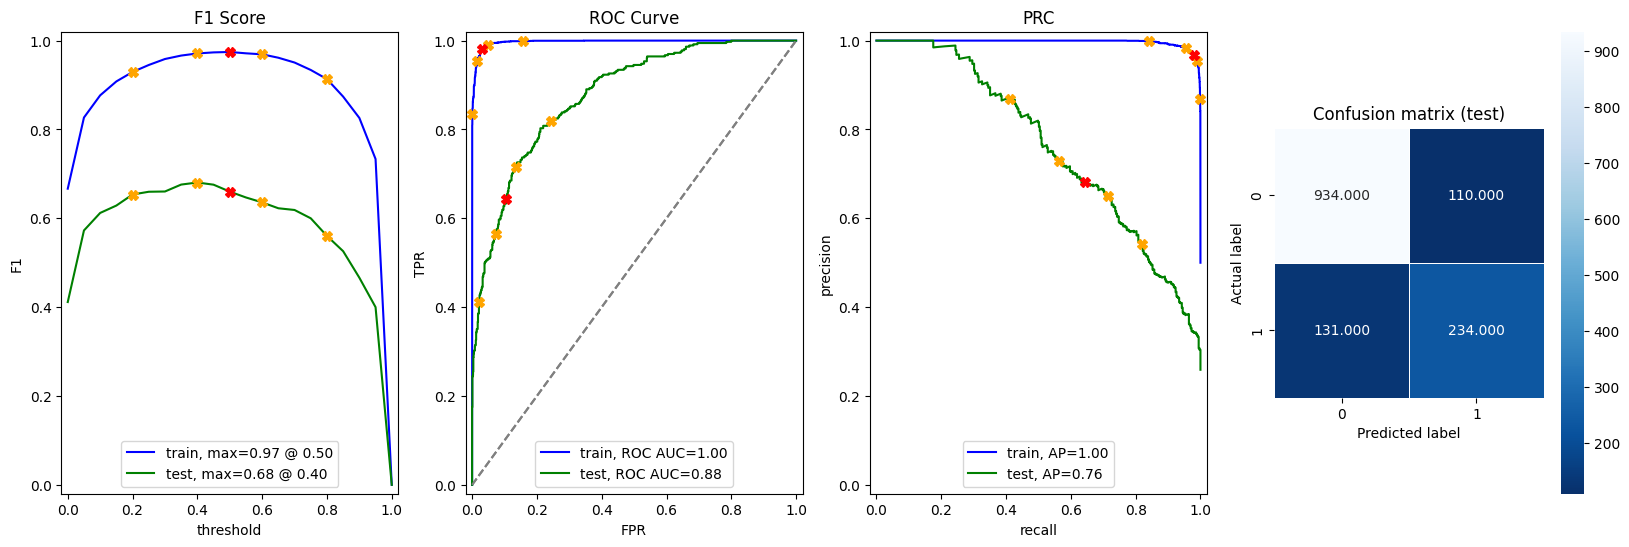

In [157]:
%%time
model_xgb = XGBClassifier(random_state=0)
pipe = Pipeline([('scaler', scaler), ('model_xgb', model_xgb)])

n_estimators = range(125, 150, 10)
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
booster = ['gbtree', 'gblinear']
reg_alpha = [0, 0.5, 1]
base_score = [0.2, 0.5, 0.9]

parameters = dict(model_xgb__n_estimators=n_estimators,
                 model_xgb__reg_alpha=reg_alpha,
                 model_xgb__base_score=base_score,
                 model_xgb__booster=booster,
                 model_xgb__learning_rate=learning_rate)

xgb_GS = GridSearchCV(pipe, parameters, cv=3, verbose=1)
xgb_GS.fit(X_train_res, y_train_res)

print('Best score:', xgb_GS.best_params_)

evaluate_model(xgb_GS, X_train_res, y_train_res, X_valid, y_valid)

### CatBoost

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best score: {'model_cat__depth': 2, 'model_cat__l2_leaf_reg': 1, 'model_cat__learning_rate': 0.4}
          train  test
Accuracy   0.96  0.87
F1         0.96  0.75
APS        0.99  0.85
ROC AUC    0.99  0.92
CPU times: user 13min 38s, sys: 6min 1s, total: 19min 39s
Wall time: 6min 54s


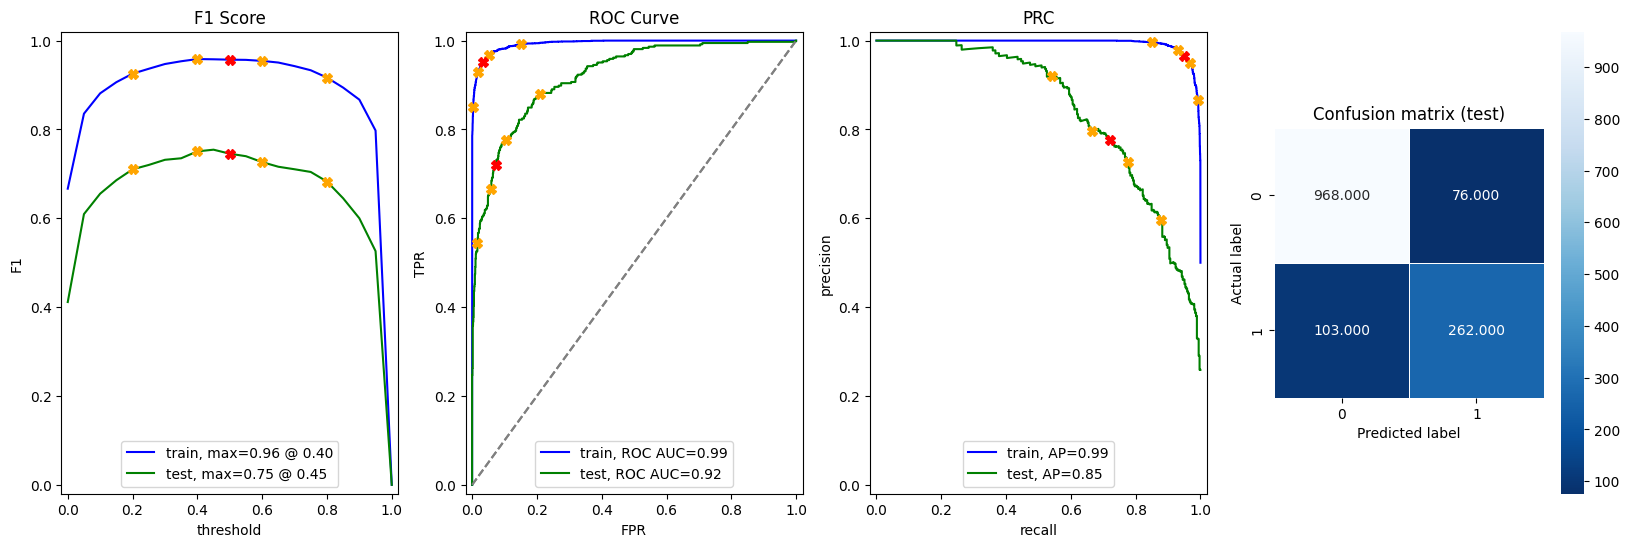

In [204]:
%%time
model_cat = CatBoostClassifier(logging_level='Silent', loss_function='Logloss', random_state=0)
pipe = Pipeline([('scaler', scaler), ('model_cat', model_cat)])

depth = range(2, 10, 2)
learning_rate = [0.1, 0.2, 0.3, 0.4]
l2_leaf_reg = [1, 3, 5, 7, 9]

parameters = dict(
                 model_cat__depth=depth,
                 model_cat__learning_rate=learning_rate,
                 model_cat__l2_leaf_reg=l2_leaf_reg
)

cat_GS = GridSearchCV(pipe, parameters, cv=3, verbose=1)
cat_GS.fit(X_train_res, y_train_res)

print('Best score:', cat_GS.best_params_)

evaluate_model(cat_GS, X_train_res, y_train_res, X_valid, y_valid)

**Conclusions**
- CatBoost performed the best on the validation set with AUC ROC score of 0.92 and accuracy of 87%.
- Summary of other models:
    - XGBoost: AUC ROC score of 0.88 and accuracy of 83%.
    - Random Forest: AUC ROC score of 0.85 and accuracy of 80%.
    - Decision Tree: AUC ROC score of 0.79 and accuracy of 76%.
    - Logistic Regression: AUC ROC score of 0.83 and accuracy of 77%.
- All models performed better than the baseline dummy model

## Final model

The final model will be the CatBoost Classifier which performed the best during hyperparameter tuning.

In [209]:
# Upsample the full training/validation set
sm = SMOTE(random_state=0)
X_train_valid_res, y_train_valid_res = sm.fit_resample(X_train_valid, y_train_valid)

In [210]:
print(y_train_valid.value_counts())
print(y_train_valid_res.value_counts())

churn
0    4133
1    1501
Name: count, dtype: int64
churn
0    4133
1    4133
Name: count, dtype: int64


          train  test
Accuracy   0.95  0.88
F1         0.95  0.76
APS        0.99  0.87
ROC AUC    0.99  0.93
CPU times: user 1.97 s, sys: 1.23 s, total: 3.21 s
Wall time: 1.46 s


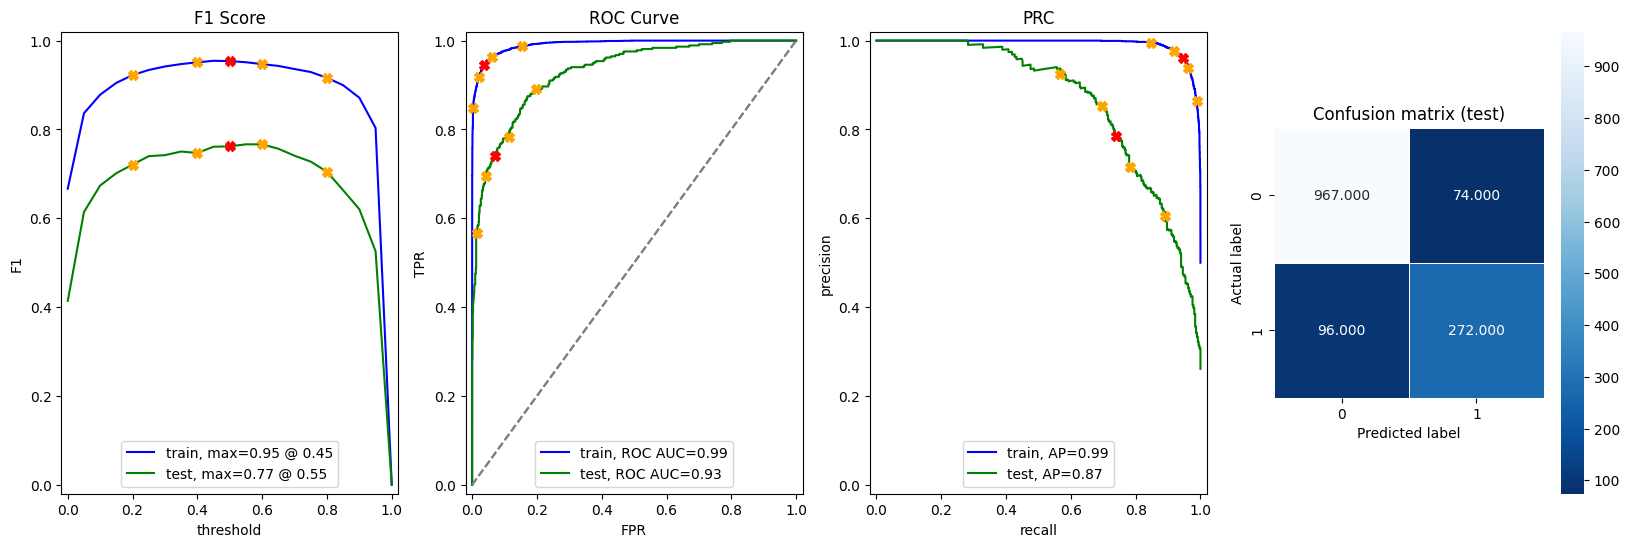

In [211]:
%%time
# use parameters from hyperparameter tuning
final_model = CatBoostClassifier(depth=2, 
                                 l2_leaf_reg=1,
                                 learning_rate=0.4,
                                 logging_level='Silent', 
                                 loss_function='Logloss', 
                                 random_state=0)

pipe = Pipeline([('scaler', scaler), ('final_model', final_model)])

pipe.fit(X_train_valid_res, y_train_valid_res)

evaluate_model(pipe, X_train_valid_res, y_train_valid_res, X_test, y_test)

- The final model performed well, with a ROC AUC score of 0.93 and accuaracy of 88%.

## Overall Conclusions

Clients had the highest churn when they enrolled in month-to-month fiber optic service and paid by electronic check. The higher churn could be related to the higher monthly cost of the fiber optic service, and perhaps the speeds they received were not worth the higher cost when compared to the lower cost of DSL. Those that enrolled in a 1 or 2-year contract were less likely to churn.

Churn at Interconnect has been steadily increasing since 2014. The model I developed will predict if a client is planning to leave with 88% accuracy. This will help the company’s marketing team target customers likely to leave and offer them promotional codes and special plan options to help reduce churn moving forward. Offering discounted 1 or 2-year plans to fiber optic clients that might leave could be an effective approach to reduce churn.